In [1]:
#basic python packages
import numpy as np
%matplotlib notebook 
import pylab as plt

#for nice progression bars in loops
from tqdm import tqdm

#network analysis package
import networkx as nx

#quantum graph package
from NAQ_graphs import NAQ



<IPython.core.display.Javascript object>


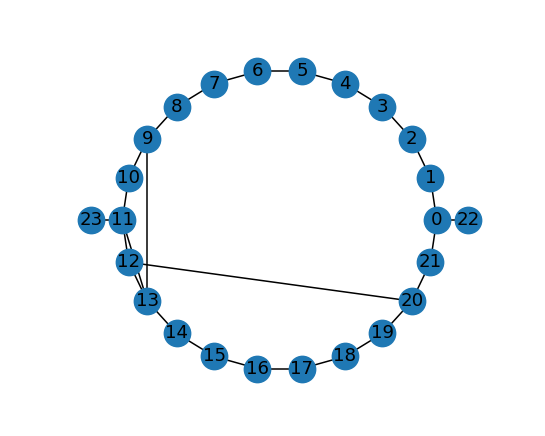

(-1.344583946946139,
 1.344583946946139,
 -1.1197330647756132,
 1.1197330647756132)

In [2]:
#we first create a graph, here is a small world with one in one out

n_nodes = 22  #number of nodes
n_neigh = 2   #number of neighbours
p       = 0.0 #probability of adding accros edges

#create the small-world graph
G = nx.newman_watts_strogatz_graph(n_nodes, n_neigh, p)

#set the positions on a circle
pos = {i: np.array([np.cos(2*np.pi*i/len(G)),np.sin(2*np.pi*i/len(G))]) for i in range(len(G))}

#add one input channel
G.add_edge(len(G),0)
pos[len(G)-1] = pos[0]+[0.2,0]

#add one ouput channel
G.add_edge(len(G),11)
pos[len(G)-1] = pos[11]+[-0.2,0]

plt.figure(figsize=(5,4))
nx.draw_networkx(G,pos=pos)
plt.axis('off')

In [3]:
#additional parameters (do not modify)
chi = np.array([ 1.j for i in range(len(G.edges))])
group = 'U1'
transport_graph = True

#create the main object
naq_u1 = NAQ(G, positions = pos, chi = chi, group = group, transport_graph = transport_graph)

#set the inputs/outputs
naq_u1.input_nodes = [len(G)-1, ]  #which nodes are input nodes (list of nodes id)
naq_u1.input_values = [1., ]       #fix the input flux on all the nodes (list of number one per input_nodes)
naq_u1.output_nodes = [len(G)-2, ] #which nodes are output nodes (list of nodes id)

#set the wavenumber
k_0 = 1.
naq_u1.update_chi(k_0) 


#after having setup the problem, we can solve it:
output_flux = naq_u1.test_laplacian()
print("Ouput flux: ", output_flux)

Ouput flux:  0.4611384004794851


<IPython.core.display.Javascript object>


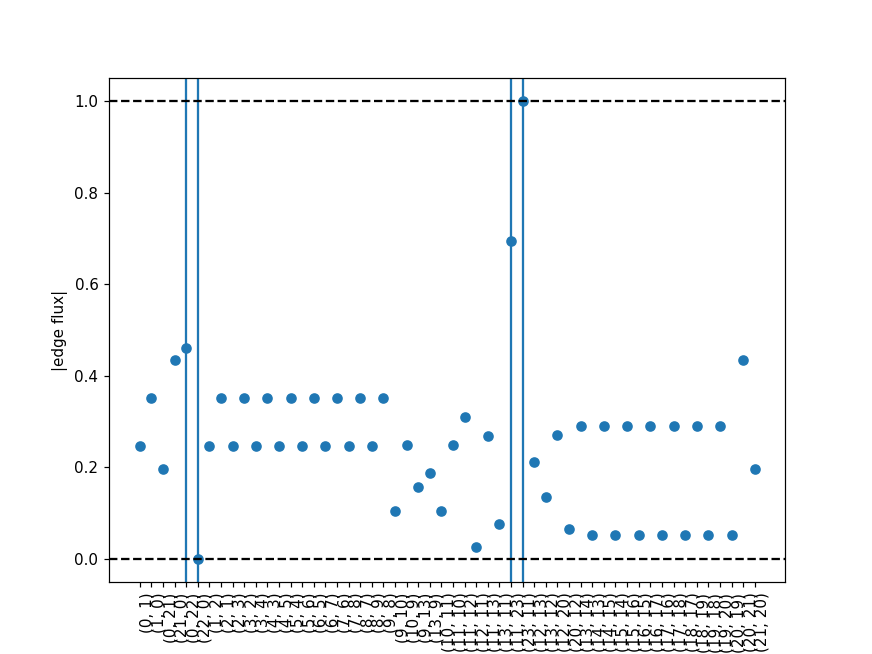

Text(0,0.5,'|edge flux|')

In [4]:
#then compute the solution on each node
sol = k_0*naq_u1.compute_solution()

#and convert it to each edge
flux = naq_u1.node_solution_to_edge_solution(sol)

#then plot it:
plt.figure(figsize=(8,6))
plt.plot(np.abs(flux),'o')

labels = [] #cpllect the edge ids for plotting
for ei, e in enumerate(list(naq_u1.graph.edges())):
        (u, v) = e[:2]
        labels.append(str((u,v)))
        labels.append(str((v,u)))

        #plot vertical lines for degree one edges
        if len(naq_u1.graph[v]) == 1:
            plt.axvline(2*ei)
            plt.axvline(2*ei+1)
                
#add x-labels     
ax = plt.gca()
ax.set_xticks(np.arange(2*len(G.edges())))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

plt.axhline(0, c='k', ls='--')
plt.axhline(naq_u1.input_values[0], c='k', ls='--')
plt.xlabel('edge')
plt.ylabel('|edge flux|')

<IPython.core.display.Javascript object>


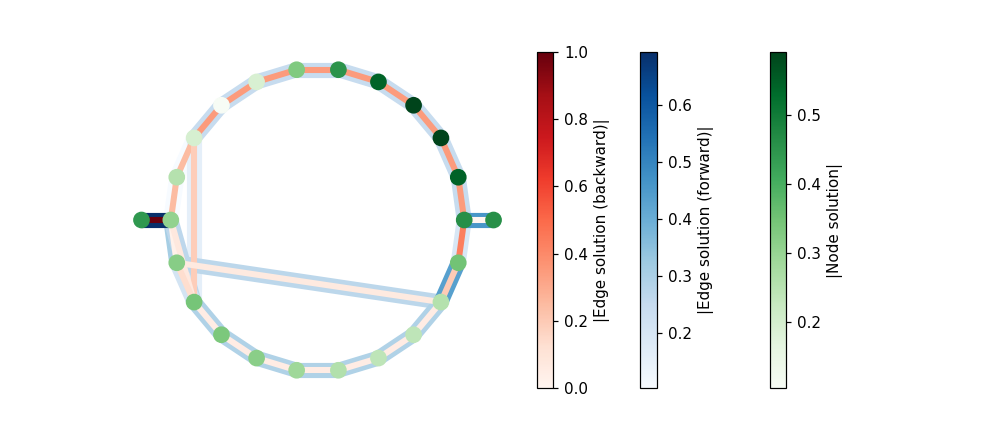

In [5]:
#plot the node and edge solution on the graph itself

#first set what to plot on nodes and edges (doubled, one for each direction)
node_solution = np.abs(sol)
edge_solution_for = np.abs(flux)[::2]
edge_solution_bac = np.abs(flux)[1::2]


plt.figure(figsize=(9,4))

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color = node_solution ,cmap = 'Greens', node_size = 100)
edges_1 = nx.draw_networkx_edges(G, pos=pos, edge_color = edge_solution_for, edge_cmap = plt.get_cmap('Blues'), width = 10)
edges_2 = nx.draw_networkx_edges(G, pos=pos, edge_color = edge_solution_bac, edge_cmap = plt.get_cmap('Reds'), width = 4)
plt.axis('off')

plt.colorbar(nodes,label='|Node solution|')
plt.colorbar(edges_1, label='|Edge solution (forward)|')
plt.colorbar(edges_2, label='|Edge solution (backward)|')


In [6]:
#scan the spectrum k, with n_k wavenumbers from k_min to k_max

k_min = 0.1
k_max = 30
n_k = 1000


K = np.linspace(k_min, k_max, n_k)
s = np.zeros(len(K))

for i in tqdm(range(n_k)):
    naq_u1.update_chi(K[i]) #first update the wavenumber
    s[i] = K[i]*naq_u1.test_laplacian() #compute the output flux (we need to multiply by the wavenumber here)


100%|██████████| 1000/1000 [00:04<00:00, 228.13it/s]


<IPython.core.display.Javascript object>


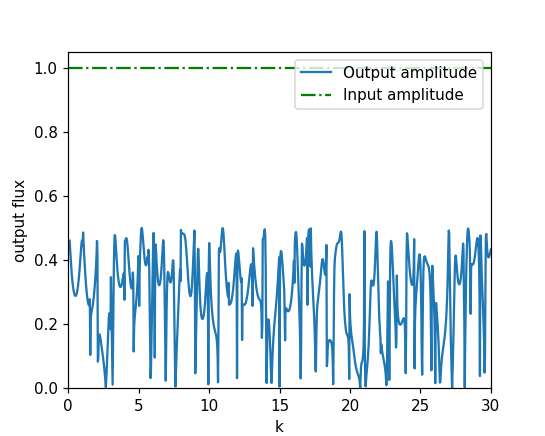

Text(0,0.5,'output flux')

In [7]:
#plot the spectrum
plt.figure(figsize=(5,4))
plt.plot(K,np.abs(s), label='Output amplitude')
plt.axhline(np.sum(naq_u1.input_values), ls='-.', c='g', label='Input amplitude')

plt.axis([0,k_max,0,np.sum(naq_u1.input_values)+0.05])

plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('output flux')
